<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-Collection-Methods" data-toc-modified-id="Data-Collection-Methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Collection Methods</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#What-are-all-the-items-that-Macy's-sells-online?" data-toc-modified-id="What-are-all-the-items-that-Macy's-sells-online?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>What are all the items that Macy's sells online?</a></span></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data Visualization</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Generalizing-to-difference-merchants" data-toc-modified-id="Generalizing-to-difference-merchants-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Generalizing to difference merchants</a></span></li></ul></li></ul></div>

# Introduction
Often data is not presented or available in convenient forms. For example, there is no convenient way to determine the number of items sold by the retailer Macy's. One convenient method for acquiring product information is by using retailers application programming interface (API). But, after contacting Macy's developer site (http://developer.macys.com/) I learned they don't provide a public API. Therefore, I programmed a web crawler to scrape product information. This notebook presents the code necessary to run a web spider with python. After crawling through www.macys.com pages, the web spider found a total of **135,342** items for sale. The median product price was \$80, with an average of \$392. The web spider proved to be an effective method for gathering, otherwise, unavailable data. Should you have a need to aggregate dispersed data, this code could easily be modified to gather relevant data. 

# Data Collection Methods
**Two different approaches:** 
    1. Directly access the application programming interface (API). This would be the most accurate and fastest to implement, assuming API access. 
    2. Build a web scraper with scrapy 1.4 framework (https://scrapy.org/). 
    
I didn't have API access. So, in the terminal, I ran the following commands to gather a list of target URLs. The URL list would later be served to scrapy for crawling.  

- scrapy shell
- fetch('https://www.macys.com')
- url_list = response.xpath('//a/@href').extract()
- url_list = [response.urljoin(x) for x in url_list if 'www' not in x]
- test_urls = open('test_urls.txt', 'w')
- for item in url_list: <br>
    ...:       test_urls.write("%s\n" % item)
- test_urls.close()

The above commands harvest links from the Macy's landing page. Then, the list is saved in a text file. test_urls.txt. Below is a sample url. 


In [1]:
with open('test_urls.txt') as f:
    urls = f.read().splitlines()
urls[21]

'https://www.macys.com/shop/womens-clothing/womens-activewear?id=29891&cm_sp=us_hdr-_-women-_-29891_activewear_COL1'

The code, macybot.py, used in the spider is displayed below, and the file can be found here: https://github.com/caheredia/Data_Science_Portfolio/blob/master/acorns/develop/macyscraper/macyscraper/spiders/macybot.py The first part of the file reads in the list of urls. Then a function is defined to extract the titles of items in each url. The title extraction is done with this line of code
> titles = response.css(".productDescLink::attr(title)").extract()

A similar method is used for prices. The next section in macybot.py zips the *titles* and *prices* into a dictionary, later saved into a csv file. The csv save commands take place in settings.py, https://github.com/caheredia/Data_Science_Portfolio/blob/master/acorns/develop/macyscraper/macyscraper/settings.py The dictionary is saved to the file macys.csv. Finally, the last section of macybot.py instructs the spider on how to proceed through urls with pagination. 

In [ ]:
# -*- coding: utf-8 -*-
import scrapy

# Read in previously saved urls from macys.com
with open('test_urls.txt') as f:
    urls = f.read().splitlines()
    
class macySpider(scrapy.Spider):
    name = 'macybot'
    allowed_domains = ['www.macys.com']
    start_urls = urls

    def parse(self, response):
        #Extracting the content using css selectors
        titles = response.css(".productDescLink::attr(title)").extract()
        #url = response.css(".productDescLink::attr(href)").extract()
        price = response.css(".regular::text").extract()
  

        #Give the extracted content row wise
        for item in zip(titles,price):
            #create a dictionary to store the scraped info
            scraped_data = {
            'title' : item[0],
            'price' : item[1].strip(),
            #'url' : response.urljoin(item[2]),
            }

            #yield or give the scraped info to scrapy
            yield scraped_data
            
        # follow pagination link 
        next_page_url = response.css(".nextPage > a::attr(href)").extract_first()
        # Check to see if next page exists
        if next_page_url:
            next_page_url = response.urljoin(next_page_url)
            yield scrapy.Request(url = next_page_url, callback = self.parse)

# Data Exploration

## What are all the items that Macy's sells online?
Below is a table with all the available items for sale, with prices included.

In [158]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline

In [223]:
# Read in csv file and display first 5 items
df = pd.read_csv( 'macys.csv')
df.head()

,title,price
0,"INC International Concepts Velvet Blazer, Cre...",$99.50
1,"Style & Co Camisole with Built-In Bra, Create...",$7.98
2,Calvin Klein Tweed Bouclé Topper Jacket,$169.00
3,Tommy Hilfiger Pinstriped Peplum Blazer,$139.00
4,"Kasper Metallic Jacquard Jacket, Regular & Pe...",$129.00


In [236]:
'Total number of items for sale on www.macys.com: {}'.format(len(df))

'Total number of items for sale on www.macys.com: 135342'

## Data Visualization

In [237]:
# Strips price column of extra chars and converts to float
df['price'] = df['price'].astype(str).map(lambda x: x.lstrip('$').rstrip(
    'aAbBcC').replace(',', '')).apply(pd.to_numeric, errors='coerce')

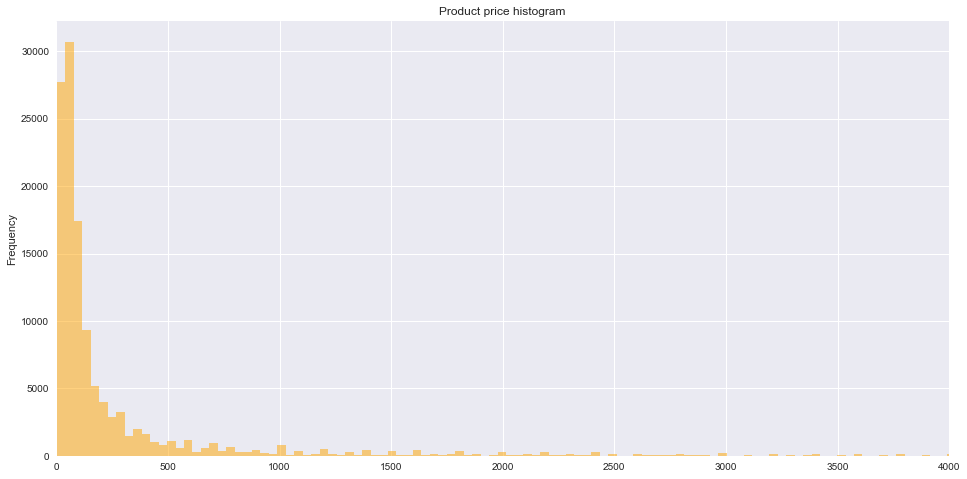

In [245]:
# Plot a histrogram of product prices.
df['price'].plot.hist(alpha = .5, color = 'orange', bins=1000, figsize=(16,8), xlim=(0,4000), title='Product price histogram');

In [219]:
print('Average product price:\t ${:.0f}'.format(df.price.mean()))
print('Median product price:\t ${:.0f}'.format(df.price.median()))
print('Minimum product price:\t ${:.0f}'.format(df.price.min()))
print('Maximum product price:\t ${:.0f}'.format(df.price.max()))

Average product price:	 $392
Median product price:	 $80
Minimum product price:	 $2
Maximum product price:	 $38000


In [243]:
# Most expensive product
df.title[df[df.price==df.price.max()].index[0]]

' Diamond Graduated Three-Row Collar Necklace (12 ct. t.w.) in 14k White Gold'

# Data Analysis 

##  Generalizing to difference merchants
This web crawler method is fairly versatile. With small changes made to the recorded parameters, i.e. *titles* and *prices* through xpath links, this crawler could be generalized to any website--assuming access was granted.

Because it could be run through a cloud service, e.g Scrapy Cloud, this method is extensible and scalable. 